This notebook implements the active Learning strategies in the basic setting in using an oop approach. The goal of this notebook is to
* clearify the process
* use algorithm setting accross multiple runs, without redefining them
* 

# 1. define the PATHS in a external function

In [1]:
import sys

basepath = "../"  # Project directory
sys.path.append(basepath)
# AL Scripts
AL_SCRIPTS_PATH = basepath + "al_lib/"

sys.path.append({AL_SCRIPTS_PATH})

from al_lib.active_learning_setting import ActiveLearningPaths

PATHS = ActiveLearningPaths()
(DATA_PATH, FIGURE_PATH, ENV_PATH, RESULTS_PATH, LOG_DIR) = PATHS
sys.path.extend(PATHS)

sys.path

['/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python312.zip',
 '/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12',
 '/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/lib-dynload',
 '',
 '/home/fhwn.ac.at/202375/.conda/envs/thesis/lib/python3.12/site-packages',
 '../',
 {'../al_lib/'},
 '../',
 '../data/',
 '/home/fhwn.ac.at/202375/.conda/envs/thesis/lib',
 '../04_Active_Learning/results/figures/',
 '../04_Active_Learning/results/',
 '../data/',
 '../04_Active_Learning/results/figures/',
 '/home/fhwn.ac.at/202375/.conda/envs/thesis/lib',
 '../04_Active_Learning/results/',
 '../04_Active_Learning/logs/']

# Include a logger

In [2]:
# import the logging specifications from file 'logging_config.py'
from al_lib.logging_config import create_logger
import datetime

# Add data/time information
date = datetime.datetime.now().strftime("%Y-%m-%d")
# date = now.strftime("%Y-%m-%d")
log_file_path = f"{LOG_DIR}active_learning_{date}.log"

# Create logger
logging = create_logger(log_file_path)
# Usage of the logger as follows:
logging.info("Logging started")
logging.info(f"log stored at: {log_file_path}")

2024-06-26 21:11:41 - INFO - Logging started
2024-06-26 21:11:41 - INFO - log stored at: ../04_Active_Learning/logs/active_learning_2024-06-26.log


# Imports
## Packages

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.kernel_ridge import KernelRidge as KRR
import pandas as pd

### sklearn warnings

In [4]:
## Turn of sklearn warnings
from warnings import simplefilter
import warnings

from sklearn.exceptions import ConvergenceWarning

simplefilter("ignore", category=ConvergenceWarning)
warnings.filterwarnings(
    "ignore", message=".*y residual is constant*.", category=UserWarning, append=False
)
# logging.warning("Warning \"y residual is constant\" turned off")

### Import Data

In [5]:
# Define the datafile

data_name = "dpsDeriv1200.csv"

datafile = DATA_PATH + data_name

from al_lib.helper_functions import import_dpsDeriv1200
import pandas as pd

data = import_dpsDeriv1200(datafile)
logging.info(f"Data loaded and preprocessed from {datafile}")

2024-06-26 21:11:43 - INFO - Data loaded and preprocessed from ../data/dpsDeriv1200.csv


## Split into feature and target variables

In [6]:
X = data.select_dtypes("float")
y = data["year"]
X.shape, y.shape

((1290, 410), (1290,))

## Validation

since not every regression method is able to estimate its prediction accuracy, a split of the data is retained as validation set. 

In [7]:
# count the number of columns with std = 0.0 in X
logging.info(
    f"{(X.std() == 0.0).sum()} Columns dropped, where std = 0.0 in X"
)

# drop the columns with std = 0.0
X = X.loc[:, X.std() != 0.0]
logging.info(
    f"X: {X.shape},y: {y.shape} Dimensions after dropping columns with std = 0.0"
)

2024-06-26 21:11:43 - INFO - 0 Columns dropped, where std = 0.0 in X
2024-06-26 21:11:43 - INFO - X: (1290, 410),y: (1290,) Dimensions after dropping columns with std = 0.0


# Train/Test/Validation Split

In [8]:
# Computational Settings
random_state = 12345

validation_size = 0.1
test_size = 0.3

from sklearn.model_selection import train_test_split

# retain 10% of the data for validation
(
    X_remainder,
    X_val,
    y_remainder,
    y_val,
) = train_test_split(X, y, test_size=validation_size, random_state=random_state)

# split the remainder into training and test (30%) set
X_train, X_test, y_train, y_test = train_test_split(
    X_remainder, y_remainder, test_size=test_size, random_state=random_state
)
logging.info(f"Split of the dataset into Train/Test/Validation set")

# assert the shapes for the sets and raise an error if they are not equal
assert X_train.shape[0] + X_test.shape[0] + X_val.shape[0] == X.shape[0], "Sum of samples in Train/Test/Validation set not equal to total samples"
assert X_train.shape[1] == X_test.shape[1] == X_val.shape[1] == X.shape[1], "Number of features in Train/Test/Validation set not equal to total features"
assert y_train.shape[0] + y_test.shape[0] + y_val.shape[0] == y.shape[0], "Sum of Sample-targets in Train/Test/Validation set not equal to total samples"
assert X_train.shape[0] == y_train.shape[0], "Number of samples not equal to number of targets in Train set"
assert X_test.shape[0] == y_test.shape[0], "Number of samples not equal to number of targets in Test set"
assert X_val.shape[0] == y_val.shape[0], "Number of samples not equal to number of targets in Validation set"

logging.info(f"Shapes of Train/Test/Validation set verified")
logging.info(f"X_train: {X_train.shape}, y_train: {y_train.shape}")

2024-06-26 21:11:43 - INFO - Split of the dataset into Train/Test/Validation set
2024-06-26 21:11:43 - INFO - Shapes of Train/Test/Validation set verified
2024-06-26 21:11:43 - INFO - X_train: (812, 410), y_train: (812,)


In [9]:
from al_lib.helper_functions import calc_set_sizes

calc_set_sizes(X_train , X_test, X_val, logging)

2024-06-26 21:11:43 - INFO - Training set: 812 (62.95%)
2024-06-26 21:11:43 - INFO - Test set: 349 (27.05%)
2024-06-26 21:11:43 - INFO - Validation set: 129 (10.0%)


# Model Parameters and Model Methods

The optimal model parameters according to the CV Results are used to to fit the individual models. 

In [10]:
# Import the Regressors

from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.kernel_ridge import KernelRidge as KRR
from sklearn.ensemble import HistGradientBoostingRegressor as HGB
from sklearn.neural_network import MLPRegressor as MLP
from sklearn.cross_decomposition import PLSRegression as PLS
from xgboost import XGBRegressor as XGB

# Define the regressors
Regressors = [RF, KRR, HGB, MLP, PLS, XGB]

In [11]:
# import the rscv model parameters from 03_Modelling/03_1_rscv

rscv_results_dir = basepath + "03_Modelling/03_1_rscv/rscv_results/"

# models tested
models = ["hgb", "krr", "mlp", "pls", "rf", "xgb"]
optimal_params = {}
rmse_from_cv = {}

for model in models:
    # load the results of the rscv as a dataframe
    rscv_results = pd.read_csv(rscv_results_dir + f"{model}_rscv_results.csv")
    # id the best parameters via min of RMSE
    opt_run = rscv_results.loc[rscv_results["RMSE"].idxmin()]
    # extract the optimal parameters
    optimal_params[model] = opt_run["params"]
    # convert the parameters to a dictionary
    optimal_params[model] = eval(optimal_params[model])
    # retrieve the optimal RMSE
    rmse_from_cv[model] = opt_run["RMSE"]
    # convert the RMSE to a float, round, and assign integer value
    rmse_from_cv[model] = round(float(rmse_from_cv[model]), 0)


Return the model parameters which are used to perform active learning. These are important, since they potentially influence the performance of the AL-processes in an influental manner.

In [12]:
for model in models:
    logging.info(f"Optimal parameters for {model} with RMSE {rmse_from_cv[model]}: {optimal_params[model]}")

2024-06-26 21:11:43 - INFO - Optimal parameters for hgb with RMSE 1237.0: {'learning_rate': 0.0628802929193671, 'loss': 'squared_error', 'max_iter': 365, 'max_leaf_nodes': 76, 'min_samples_leaf': 37}
2024-06-26 21:11:43 - INFO - Optimal parameters for krr with RMSE 107.0: {'alpha': np.float64(0.0006739020867475914), 'gamma': np.float64(97508.38435276879), 'kernel': 'polynomial'}
2024-06-26 21:11:43 - INFO - Optimal parameters for mlp with RMSE 155.0: {'activation': 'identity', 'alpha': np.float64(0.011423210271875284), 'early_stopping': False, 'hidden_layer_sizes': 53, 'solver': 'lbfgs', 'validation_fraction': np.float64(0.13269784027286136)}
2024-06-26 21:11:43 - INFO - Optimal parameters for pls with RMSE 148.0: {'copy': True, 'max_iter': 339, 'n_components': 12, 'scale': True, 'tol': np.float64(0.6786318868399671)}
2024-06-26 21:11:43 - INFO - Optimal parameters for rf with RMSE 146.0: {'max_depth': 12, 'max_features': 7, 'min_samples_split': 9, 'n_estimators': 23}
2024-06-26 21:11:

In [13]:
# generate object with the optimized parameters to hand over to the Regressors
for key in optimal_params.keys():
    # generate a global variable with the optimal parameters
    globals()[f"params_{key}"] = optimal_params[key]


for key in optimal_params.keys():
    logging.info(f"Optimal parameters for {key}: {optimal_params[key]}")

2024-06-26 21:11:43 - INFO - Optimal parameters for hgb: {'learning_rate': 0.0628802929193671, 'loss': 'squared_error', 'max_iter': 365, 'max_leaf_nodes': 76, 'min_samples_leaf': 37}
2024-06-26 21:11:43 - INFO - Optimal parameters for krr: {'alpha': np.float64(0.0006739020867475914), 'gamma': np.float64(97508.38435276879), 'kernel': 'polynomial'}
2024-06-26 21:11:43 - INFO - Optimal parameters for mlp: {'activation': 'identity', 'alpha': np.float64(0.011423210271875284), 'early_stopping': False, 'hidden_layer_sizes': 53, 'solver': 'lbfgs', 'validation_fraction': np.float64(0.13269784027286136)}
2024-06-26 21:11:43 - INFO - Optimal parameters for pls: {'copy': True, 'max_iter': 339, 'n_components': 12, 'scale': True, 'tol': np.float64(0.6786318868399671)}
2024-06-26 21:11:43 - INFO - Optimal parameters for rf: {'max_depth': 12, 'max_features': 7, 'min_samples_split': 9, 'n_estimators': 23}
2024-06-26 21:11:43 - INFO - Optimal parameters for xgb: {'colsample_bytree': 0.8237144912311207, 

In [14]:
# Accessing the optimal parameters
params_krr

{'alpha': np.float64(0.0006739020867475914),
 'gamma': np.float64(97508.38435276879),
 'kernel': 'polynomial'}

# Active Learning Setup

The Basic Active Learning Experiment follows the specifications:

* Implementation of each Sampling Strategy in a Modular fashion
* Selecting the inital samples randomly
* Refitting the model after each selected sample
* Runing the experiment n-fold with differing random states
* Calculation of mean performance with confidence intervalls
* Visualizing the results

# Definining the Active Learning Settings

In [15]:
# Perform active Learning for n_iterations
n_iterations = 5

# Define the number of samples to be queried in each iteration 
# (other values evaluated in another experiment)
n_samples_per_it = 1

# Initial sample size
initial_sample_size = 10

# Define the sampling strategy - specific parameters

In [16]:
from al_lib.selection_criteria import (_random_selection,
                                       _gsx_selection, 
                                       _gsy_selection, 
                                       _uncertainty_selection)

# Defining the active Learning Framework

In [17]:
from al_lib.helper_functions import _validate_parameters
from al_lib.helper_functions import _rnd_initial_sampling
from al_lib.helper_functions import rmse_func
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit


n_jobs = 20

n_samples_per_it = 1
init_sample_size = 10
n_iterations = 2
n_fold = 4

def active_learning(
    X_train,
    X_test,
    X_val,
    y_train,
    y_test,
    y_val,
    model_class=None,
    model_params={},
    selection_criterion=None,
    n_iterations=None,
    n_samples_per_it=None,
    init_sample_size=None,
    random_state=None,
    n_jobs=None,
    **kwargs,
):
    """
    Function to perform any (of the selected) regression methods
    with Uncertainty Sampling as selection criterion
    """
    if 'n_fold' in kwargs:
        n_fold = kwargs['n_fold']
    else:
        n_fold = 3 # 

    # _validate_parameters(
    #     X_train,
    #     y_train,
    #     model_class=None,
    #     model_params={},
    #     selection_criterion=None,
    #     n_iterations=None,
    #     n_samples_per_it=None,
    #     init_sample_size=None,
    # )

    logging.info(
        f"\nSize of X_train: {X_train.shape}"
        + f"\nSize of y_train: {y_train.shape}"
        + f"\nSize of model_class: {model_class}"
        + f"\nSize of model_params: {model_params}"
        + f"\nSelection Criterion: {selection_criterion}"
        + f"\nKey word arguments: {kwargs}"
    )
    if n_samples_per_it is None:
        n_samples_per_it = 1
    if init_sample_size is None:
        init_sample_size = 10
    if n_iterations is None:
        n_iterations = 50
    if random_state is None:
        random_state = 12345
    


    # Initialize the model
    model = model_class(**model_params)
    # Initialize the active learning model
    X_Pool = X_train
    y_Pool = y_train

    # prepare the output objects
    rmse_sampling = np.zeros(n_iterations)
    rmse_validation = np.zeros(n_iterations)
    samples_selected = np.zeros(n_iterations)
    selection_value_storage = np.zeros(n_iterations)

    # initialize the learned set as a empty dataframe
    X_Learned = pd.DataFrame()
    y_Learned = pd.Series()
    
    # Initialize the model
    X_Learned, y_Learned, X_Pool, y_Pool = _rnd_initial_sampling(X_Pool, X_Learned, y_Pool, y_Learned, init_sample_size, random_state)

    model.fit(X_Learned, y_Learned)

    logging.info(f"Initial model fitted with {init_sample_size} samples")

    logging.info("--Active Learning starts--")
    for it in range(n_iterations):
        logging.info(f"Active Learning with {selection_criterion} - iteration: {it}")

        y_pred_pool = model.predict(X_Pool)
        # convert y_pred_pool to a 
        y_pred_pool = pd.Series(y_pred_pool, index=X_Pool.index)

        # uncertainty_criteria_(X_Pool, y_Pool, X_Learned, y_Learned, y_pred_pool, n_fold)
        sample_id, selection_value = selection_criterion(X_Pool = X_Pool, 
                                        y_Pool = y_Pool,
                                        X_Learned = X_Learned,
                                        y_Learned = y_Learned,
                                        y_pred_pool = y_pred_pool,
                                        n_fold = n_fold, 
                                        random_state = random_state, 
                                        logging = logging, 
                                        model = model,
                                        n_jobs = n_jobs,
                                        kwargs = kwargs)
        
        samples_selected[it] = sample_id
        selection_value_storage[it] = selection_value
        logging.info(f"Sample_id: {sample_id} with selection value {selection_value}")

        # Update the Sample sets
        x_new = X_Pool.loc[[sample_id]]
        y_new = y_Pool.loc[[sample_id]]
        X_Learned = pd.concat([X_Learned, x_new], ignore_index=True)
        y_Learned = pd.concat([y_Learned, y_new], ignore_index=True)
        X_Pool = X_Pool.drop(index=sample_id)
        y_Pool = y_Pool.drop(index=sample_id)

        # Update the Model
        # retrain model on the new full data set and predict a new fit, if the n_samples_per_it is reached
        if n_samples_per_it == None or n_samples_per_it == 1:
            model.fit(X_Learned, y_Learned)
            y_pred = model.predict(X_test)
            rmse_sampling[it] = rmse_func(y_test, y_pred)
            y_pred_val = model.predict(X_val)
            rmse_validation[it] = rmse_func(y_val, y_pred_val)
        if it % n_samples_per_it == 0 and it != 0:
            model.fit(X_Learned, y_Learned)
            y_pred = model.predict(X_test)
            rmse_sampling[it] = rmse_func(y_test, y_pred)
            y_pred_val = model.predict(X_val)
            rmse_validation[it] = rmse_func(y_val, y_pred_val)

    # calc the rmse for the model including all training data
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse_full = rmse_func(y_test, y_pred)

    # # plot the rmse over the iterations
    # plt.plot(range(n_iterations)[1:], rmse_sampling[1:])
    # # add a line for the model with all training samples
    # plt.axhline(y=rmse_full, color="r", linestyle="--")
    # selection_criterion_str = str(selection_criterion).split(" ")[1]
    # plt.title(
    #     f"RMSE over Iterations with {model_class} and\n {selection_criterion} as selection criterion \n {selection_criterion_str} as selection criterion"
    # )
    # plt.xlabel("Iteration")
    # plt.ylabel("RMSE")
    # # plt.show()
    return rmse_sampling, rmse_validation, samples_selected, rmse_full

In [20]:
def test_active_learning():
    """
    Function to test the active learning function
    """
    from al_lib.helper_functions import _create_test_data
    from al_lib.helper_functions import _test_params_krr


    # create test data
    X_train, X_test, X_val, y_train, y_test, y_val = _create_test_data()
    # Perform active Learning for n_iterations
    n_iterations = 5
    n_samples_per_it = 1
    initial_sample_size = 10
    model_params=_test_params_krr()
    model_class=KRR
    # Perform active learning
    rmse_sampling, rmse_validation, samples_selected, rmse_full = active_learning(
        X_train,
        X_test,
        X_val,
        y_train,
        y_test,
        y_val,
        model_class=model_class,
        model_params=model_params,
        selection_criterion=_uncertainty_selection,
        n_samples_per_it=n_samples_per_it,
        n_iterations=n_iterations,
        init_sample_size=initial_sample_size,
    )

    return rmse_sampling, rmse_validation, samples_selected, rmse_full

rmse_sampling, rmse_validation, samples_selected, rmse_full = test_active_learning()

assert rmse_sampling.shape[0] == rmse_validation.shape[0] == samples_selected.shape[0], "Shapes of output arrays not equal"


2024-06-26 21:12:38 - INFO - 
Size of X_train: (63, 3)
Size of y_train: (63,)
Size of model_class: <class 'sklearn.kernel_ridge.KernelRidge'>
Size of model_params: {'alpha': 1.0, 'kernel': 'linear', 'gamma': None, 'degree': 3, 'coef0': 1}
Selection Criterion: <function _uncertainty_selection at 0x7f87a88f9260>
Key word arguments: {}
/home/fhwn.ac.at/202375/Zamberger_thesis_AL2024/04_Active_Learning/../al_lib/helper_functions.py:282: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  y_Learned = pd.concat([y_Learned, y_new], ignore_index=True)
2024-06-26 21:12:38 - INFO - Initial model fitted with 10 samples
2024-06-26 21:12:38 - INFO - --Active Learning starts--
2024-06-26 21:12:38 - INFO - Active Learning with <function _uncertainty_selection at 0x7f87a88f9260> - iteration:

(array([0.31411417, 0.31407043, 0.31266282, 0.31187478, 0.31199533]),
 array([0.27920047, 0.27856575, 0.27454782, 0.26071445, 0.26010585]),
 array([37., 19., 76., 52.,  8.]),
 np.float64(0.3146497828345244))

## Main Experiment

Here we want to compare all selection strategies for each model individually. Each selection strategy will be applied multiple times ('n_al_iterations') to calculate statistics for each selection strategy

In [ ]:
# Define the models
models = [RF, KRR, HGB, MLP, PLS, XGB]
params = [params_rf, params_krr, params_hgb, params_mlp, params_pls, params_xgb]

model_params_list = [{model: param} for model, param in zip(models, params)]

selection_criteria = [
    {"_random_selection": _random_selection, "kwargs": {}},
    {"_gsx_selection": _gsx_selection, "kwargs": {}},
    {"_gsy_selection": _gsy_selection, "kwargs": {}},
    {"_uncertainty_selection": _uncertainty_selection, "kwargs": {"n_fold": 3}},
]

# Main Experiment

The main experiment compares the performance of the various selection strategies statistically. To this end each selection strategy is performed multiple times for each model-class.

2024-06-26 20:32:43 - INFO - Current criterion kwargs: {}
2024-06-26 20:32:43 - INFO - 
Size of X_train: (812, 410)
Size of y_train: (812,)
Size of model_class: <class 'sklearn.ensemble._forest.RandomForestRegressor'>
Size of model_params: {'max_depth': 12, 'max_features': 7, 'min_samples_split': 9, 'n_estimators': 23}
Selection Criterion: <function _random_selection at 0x7fe2f240e160>
Key word arguments: {}


/home/fhwn.ac.at/202375/Zamberger_thesis_AL2024/04_Active_Learning/../al_lib/helper_functions.py:277: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  y_Learned = pd.concat([y_Learned, y_new], ignore_index=True)
2024-06-26 20:32:43 - INFO - Initial model fitted with 10 samples
2024-06-26 20:32:43 - INFO - --Active Learning starts--
2024-06-26 20:32:43 - INFO - Active Learning loop - iteration: 0
2024-06-26 20:32:43 - INFO - Sample_id: 653 with selection value None
2024-06-26 20:32:43 - INFO - Active Learning loop - iteration: 1
2024-06-26 20:32:43 - INFO - Sample_id: 1153 with selection value None
2024-06-26 20:32:43 - INFO - Active Learning loop - iteration: 2
2024-06-26 20:32:43 - INFO - Sample_id: 181 with selection value None
2024-06-26 20:32:43 - INFO - Active Learnin

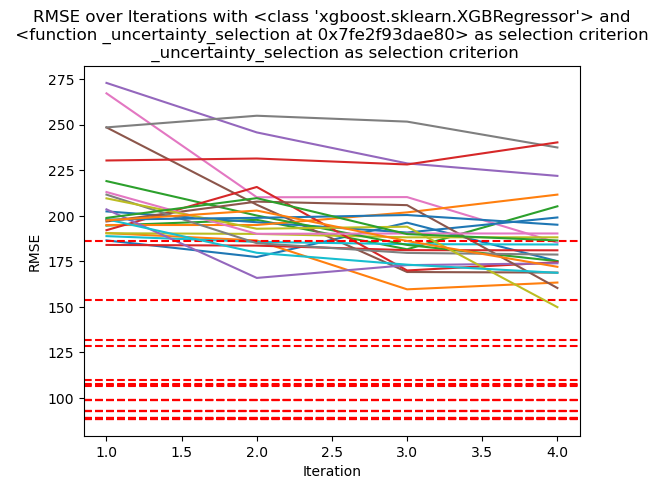

In [ ]:
# Main Experiment 

# Define the models
models = [RF, KRR, HGB, MLP, PLS, XGB]
params = [params_rf, params_krr, params_hgb, params_mlp, params_pls, params_xgb]

model_params_list = zip(models, params)

# number of active learning iterations
n_al_iterations = 3
# Define the number of iterations for each active learning iteration
n_iterations = 5

# Define the number of samples to be queried in each iteration
n_samples_per_it = 1

# Define the initial sample size
init_sample_size = 10

# Define the number of folds for the cross-validation during uncertainty sampling
n_fold = 3

# Define the random state
random_state = 12345

# Define the number of jobs
n_jobs = 20

# Define the output object

selection_criteria = [
    {'criteria':_random_selection, 'kwargs': {}}, #'random_state': random_state}}, 
    {'criteria':_gsx_selection, 'kwargs': {}}, 
    {'criteria':_gsy_selection, 'kwargs': {}}, 
    {'criteria':_uncertainty_selection, 'kwargs': {'n_fold': 3, 'logging': logging}},
                      ]

#prepare the results dataframe
for model in models:
    for criteria in selection_criteria:
        # create a global variable with the model and criterion
        globals()[f"{model}_{criteria}"] = pd.DataFrame(
            index=range(n_al_iterations), columns=range(n_iterations)
        )


for i in range(n_al_iterations):
    for model, param in model_params_list:
        for criteria in selection_criteria:
            logging.info(f"Current criterion kwargs: {criteria['kwargs']}")
            kwargs = criteria.get('kwargs', {})
            results[f"{model}_{criteria}_run{i}"] = active_learning(
                X_train,
                X_test,
                X_val,
                y_train,
                y_test,
                y_val,
                model_class=model,
                model_params=param,
                selection_criterion=criteria['criteria'],
                n_iterations=n_iterations,
                n_samples_per_it=n_samples_per_it,
                init_sample_size=init_sample_size,
                random_state=random_state,
                n_jobs=n_jobs,
                **kwargs,
            )
            # store the results in the dataframe
            globals()[f"{model}_{criteria}"].iloc[i] = results[f"{model}_{criteria}_run{i}"][0]

# Results of the main experiment

We are intrested in the results of each selection strategy for each model class. For this we plot the mean performance, with uncertainty intervalls. 

In [ ]:
# plot the results for [f"{model}_{criteria}"]



In [ ]:
# generate plots for the results 
for model, in model_params_list:
    for criteria in selection_criteria:
        for i in range(n_al_iterations):
            rmse_sampling, rmse_validation, samples_selected, rmse_full = results[f'{model}_{criteria}_run{i}']
            

2024-06-26 18:18:30 - INFO - 
Size of X_train: (812, 410)
Size of y_train: (812,)
Size of model_class: <class 'sklearn.kernel_ridge.KernelRidge'>
Size of model_params: {'alpha': np.float64(0.0006739020867475914), 'gamma': np.float64(97508.38435276879), 'kernel': 'polynomial'}
Selection Criterion: <function _uncertainty_selection at 0x7fe2f93dae80>
Key word arguments: {}
/home/fhwn.ac.at/202375/Zamberger_thesis_AL2024/04_Active_Learning/../al_lib/helper_functions.py:277: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  y_Learned = pd.concat([y_Learned, y_new], ignore_index=True)
2024-06-26 18:18:30 - INFO - Initial model fitted with 10 samples
2024-06-26 18:18:30 - INFO - --Active Learning starts--
2024-06-26 18:18:30 - INFO - Active Learning loop - iteration: 0
2024-06-26 

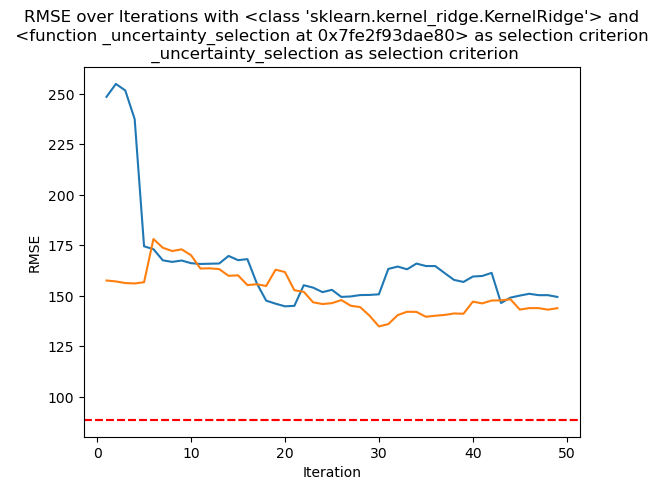

In [ ]:
# Define the selection criteria
selection_criteria = [
    {'criterion':_random_selection, 'kwargs': (random_state)}, 
    {'criterion':_gsx_selection, 'kwargs': None}, 
    {'criterion':_gsy_selection, 'kwargs': None}, 
    {'criterion':_uncertainty_selection, 'kwargs': (n_fold, random_state , logging)},
                      ]

# Define the models
models = [RF, KRR, HGB, MLP, PLS, XGB]
params = [params_rf, params_krr, params_hgb, params_mlp, params_pls, params_xgb]

model_params_list = zip(models, params)

# number of active learning iterations
n_al_iterations = 2
# Define the number of iterations for each active learning iteration
n_iterations = 50

# Define the number of samples to be queried in each iteration
n_samples_per_it = 1

# Define the initial sample size
init_sample_size = 10

# Define the number of folds for the cross-validation
n_fold = 3

rmse_sampling_n5 = pd.DataFrame(columns = range(n_al_iterations), index = range(n_iterations))
rmse_validation_n5 = pd.DataFrame(columns = range(n_al_iterations), index = range(n_iterations))
samples_selected_n5 =pd.DataFrame(columns = range(n_al_iterations), index = range(n_iterations))
rmse_full_n5 = pd.DataFrame(columns = range(n_al_iterations), index = range(n_iterations))

for i in range(n_al_iterations):
    random_state = 12345 + i
    rmse_sampling, rmse_validation, samples_selected, rmse_full = active_learning(
        X_train,
        X_test,
        X_val,
        y_train,
        y_test,
        y_val,
        model_class=KRR,
        model_params=params_krr,
        selection_criterion=_uncertainty_selection,
        n_iterations=n_iterations,
        init_sample_size=10,
        random_state=random_state,
        )
    rmse_sampling_n5[i] = rmse_sampling
    rmse_validation_n5[i] = rmse_validation
    samples_selected_n5[i] = samples_selected
    rmse_full_n5[i] = rmse_full

In [ ]:
rmse_sampling_n5

,0,1
0,277.737570,160.043706
1,248.502269,157.575825
2,254.900136,157.124094
3,251.671505,156.317380
4,237.484992,156.108900
5,174.511931,156.726016
6,173.084125,178.105433
7,167.548518,173.787291
8,166.786509,172.166940
9,167.478280,172.995958


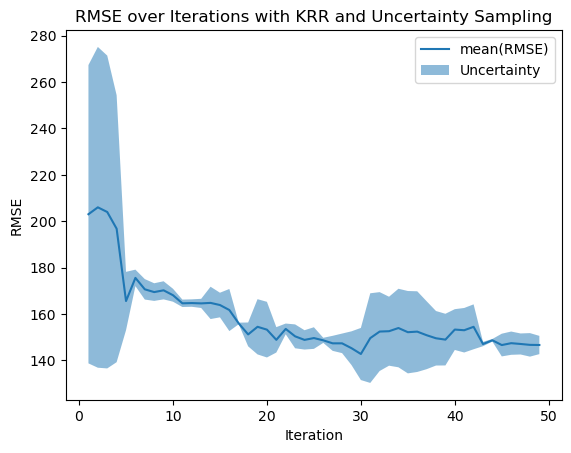

In [ ]:
# calculate the uncertainty of the RMSE in rmse_sampling_n5
rmse_sampling_n5_uncertainty = rmse_sampling_n5.std(axis=1)

# calculate the uncertainty of the RMSE in rmse_validation_n5
rmse_validation_n5_uncertainty = rmse_validation_n5.std(axis=1)

# plot the RMSE over the iterations with the uncertainty
plt.plot(range(n_iterations)[1:], rmse_sampling_n5.mean(axis=1)[1:])
plt.fill_between(
    range(n_iterations)[1:],
    rmse_sampling_n5.mean(axis=1)[1:] - rmse_sampling_n5_uncertainty[1:],
    rmse_sampling_n5.mean(axis=1)[1:] + rmse_sampling_n5_uncertainty[1:],
    alpha=0.5,
)
plt.title("RMSE over Iterations with KRR and Uncertainty Sampling")
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.legend(["mean(RMSE)", "Uncertainty"])
plt.show()

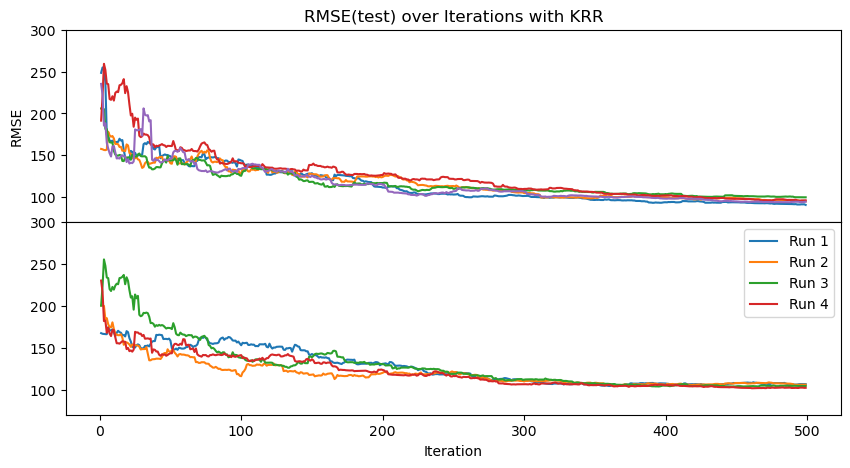

In [ ]:
#create 2 subplots
fig, ax = plt.subplots(2, 1, figsize=(10, 5), sharey=True)
fig.subplots_adjust(hspace=0)
ax[0].plot(range(n_iterations)[1:], rmse_sampling_n5[0][1:])
ax[0].plot(range(n_iterations)[1:], rmse_sampling_n5[1][1:])
ax[0].plot(range(n_iterations)[1:], rmse_sampling_n5[2][1:])
ax[0].plot(range(n_iterations)[1:], rmse_sampling_n5[3][1:])
ax[0].plot(range(n_iterations)[1:], rmse_sampling_n5[4][1:])
ax[0].set_ylim(70,300)
ax[0].set_title("RMSE(test) over Iterations with KRR")
ax[0].set_xlabel("Iteration")
ax[0].set_ylabel("RMSE")
legend_labels = ["RMSE Sampling 1", "RMSE Sampling 2", "RMSE Sampling 3", "RMSE Sampling 4", "RMSE Sampling 5"]
plt.legend(["Iteration 1", "Iteration 2", "Iteration 3", "Iteration 4", "Iteration 5"])

ax[1].plot(range(n_iterations)[1:], rmse_validation_n5[1][1:])
ax[1].plot(range(n_iterations)[1:], rmse_validation_n5[2][1:])
ax[1].plot(range(n_iterations)[1:], rmse_validation_n5[3][1:])
ax[1].plot(range(n_iterations)[1:], rmse_validation_n5[4][1:])
#ax[1].set_title("RMSE(val) over Iterations with KRR")
ax[1].set_xlabel("Iteration")
ax[1].set_ylim(70,300)
plt.legend(["Run 1", "Run 2", "Run 3", "Run 4", "Run 5"])

plt.show()